In [9]:
import pandas as pds

from sklearn import linear_model
from sklearn import metrics
from sqlalchemy import create_engine

# Import Dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, MetaData, Table

# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn.svm import SVC

# test classification dataset
from collections import Counter
from sklearn.datasets import make_classification

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import tensorflow as tf

import numpy as np

import random

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import matplotlib.pyplot as plt

import pgeocode
import censusgeocode as cg


In [10]:
# Create an engine for the chinook.sqlite database
# engine = create_engine("austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com", echo=False)
import psycopg2 as pg
import pandas.io.sql as psql
connection = pg.connect("host=austincrime.cszdqowqamd3.us-east-1.rds.amazonaws.com dbname=austincrime user=postgres password=T1m3T0Party")
# dataframe = psql.read_sql('SELECT * FROM product_product', connection)
# product_category = psql.read_sql_query('select * from product_category', connection)

In [11]:
# create crime_census_df dataframe from postgres austincrimereport_with_censustract table
crime_census_df = psql.read_sql('SELECT * FROM austincrimereport_with_censustract', connection)

In [12]:
# Generate our categorical variable list
crime_cat = crime_census_df.dtypes[crime_census_df.dtypes == "object"].index.tolist()

In [13]:
print(crime_cat)

['ID', 'GOHighestOffDesc', 'NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDate', 'ReportDate', 'LocationType', 'Address', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'Clearance', 'ClearanceDate', 'UCRCategory', 'CategoryDescription', 'Latitude', 'Longitude', 'Location', 'the_geom', 'County', 'Loc']


In [14]:
# Changing Longitude and Latitude to float

crime_census_df["Longitude"] = crime_census_df.Longitude.astype(float)
crime_census_df["Latitude"] = crime_census_df.Latitude.astype(float)

In [15]:
# Dropping columns
cleaned_crime_census_df = crime_census_df.drop(['ID','GOHighestOffDesc','Location', 'ClearanceDate', 'Clearance','XCoordinate','YCoordinate','Location','Address','ReportDateTime','ReportDate','ReportTime', 'the_geom', 'County', 'Loc'],axis = 1)
print(cleaned_crime_census_df.count())

NIBRSUCROffDesc                                      74128
FamilyViolence                                       74128
OccurredDateTime                                     74109
OccurredDate                                         74128
OccurredTime                                         74125
LocationType                                         74025
ZipCode                                              74128
CouncilDistrict                                      73893
APDSector                                            74128
APDDistrict                                          74128
PRA                                                  74128
CensusTract                                          74128
UCRCategory                                          74128
CategoryDescription                                  74128
Latitude                                             72713
Longitude                                            72713
Census_Tract                                         741

In [16]:
# Setting pgeocode variable to user United States
nomi = pgeocode.Nominatim('US')

In [18]:
#iterating through rows assinging lats and longs to Rape crimes

for i,row in cleaned_crime_census_df.iterrows():
    if row['CategoryDescription'] == 'Rape':
        location = nomi.query_postal_code(row["ZipCode"])
        cleaned_crime_census_df["Latitude"][i] = location.latitude
        cleaned_crime_census_df["Longitude"][i] = location.longitude

In [19]:
cleaned_crime_census_df.CategoryDescription.value_counts()

Theft                 53120
Burglary               8021
Auto Theft             5230
Aggravated Assault     4476
Robbery                1948
Rape                   1271
Murder                   62
Name: CategoryDescription, dtype: int64

In [22]:
cleaned_crime_census_df.CategoryDescription.value_counts()

Theft                 52801
Burglary               7956
Auto Theft             5203
Aggravated Assault     4410
Robbery                1934
Rape                   1265
Murder                   62
Name: CategoryDescription, dtype: int64

# Grouping outcomes

In [28]:
cleaned_crime_census_df.columns

Index(['NIBRSUCROffDesc', 'FamilyViolence', 'OccurredDateTime', 'OccurredDate',
       'OccurredTime', 'LocationType', 'ZipCode', 'CouncilDistrict',
       'APDSector', 'APDDistrict', 'PRA', 'CensusTract', 'UCRCategory',
       'CategoryDescription', 'Latitude', 'Longitude', 'Census_Tract',
       'AREA_SQMI', 'EstimatedTotalPopulation', 'EstimatedPersonsBelowPoverty',
       'EstimatedPctPersonsBelowPoverty',
       'FlagPctPersonsInPovertyIn90thPercentile', 'EstimatedUnemployed',
       'UnemploymentRateEstimate', 'FlagPctCivilianUnemployedIn90thPercentile',
       'PctPersonsNoHighSchoolDiploma',
       'FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile',
       'PerCapitaIncomeEstimate', 'FlagPerCapitaIncomeIn90thPercentile',
       'SumOfFlagsForSocioeconomicStatus'],
      dtype='object')

In [29]:
cleaned_crime_census_df['CategoryDescription'].unique()

array(['Theft', 'Rape', 'Burglary', 'Aggravated Assault', 'Robbery',
       'Auto Theft', 'Murder'], dtype=object)

In [30]:
# violent crime is murder, aggravated assualt, robbery, and rape
grouped_crime_census_df = cleaned_crime_census_df.copy()

grouped_crime_census_df = grouped_crime_census_df.replace({'CategoryDescription': {'Rape': 'Violent Crime', 'Murder': 'Violent Crime', 
                                                  'Aggravated Assault':'Violent Crime', 'Robbery': 'Violent Crime'}})

#for i,row in grouped_crime_df.iterrows():
#    if row['CategoryDescription'] == ('Rape' or 'Murder'or 'Aggravated Assault', 'Robbery'):
#        grouped_crime_df["CategoryDescription"][i] = "Violent Crime"

# Drop NaNs

In [32]:
# Check for null values
#cleaned_crime_df.isnull().sum()
grouped_crime_census_df.isnull().sum()

NIBRSUCROffDesc                                      0
FamilyViolence                                       0
OccurredDateTime                                     0
OccurredDate                                         0
OccurredTime                                         0
LocationType                                         0
ZipCode                                              0
CouncilDistrict                                      0
APDSector                                            0
APDDistrict                                          0
PRA                                                  0
CensusTract                                          0
UCRCategory                                          0
CategoryDescription                                  0
Latitude                                             0
Longitude                                            0
Census_Tract                                         0
AREA_SQMI                                            0
EstimatedT

In [33]:
# Drop the null rows
grouped_crime_census_df = grouped_crime_census_df.dropna()
print(grouped_crime_census_df.count())

NIBRSUCROffDesc                                      73631
FamilyViolence                                       73631
OccurredDateTime                                     73631
OccurredDate                                         73631
OccurredTime                                         73631
LocationType                                         73631
ZipCode                                              73631
CouncilDistrict                                      73631
APDSector                                            73631
APDDistrict                                          73631
PRA                                                  73631
CensusTract                                          73631
UCRCategory                                          73631
CategoryDescription                                  73631
Latitude                                             73631
Longitude                                            73631
Census_Tract                                         736

In [34]:
# checking number of unique values per column
grouped_crime_census_df.nunique()

NIBRSUCROffDesc                                         51
FamilyViolence                                           2
OccurredDateTime                                     64543
OccurredDate                                          2628
OccurredTime                                          1440
LocationType                                            43
ZipCode                                                 38
CouncilDistrict                                         10
APDSector                                               12
APDDistrict                                             15
PRA                                                    242
CensusTract                                             90
UCRCategory                                             16
CategoryDescription                                      4
Latitude                                             16521
Longitude                                            16521
Census_Tract                                            

In [36]:
# separating out month and day 
grouped_crime_census_df['OccurredDate_Month'] = pds.DatetimeIndex(grouped_crime_census_df['OccurredDate']).month
grouped_crime_census_df['OccurredDate_Day'] = pds.DatetimeIndex(grouped_crime_census_df['OccurredDate']).day
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,EstimatedUnemployed,UnemploymentRateEstimate,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day
0,600,N,2020-06-26 21:00:00,2020-06-26,2100.0,RESIDENCE / HOME,78745,2,DA,3,...,216,8.8,False,22.2,False,23448,False,0,6,26
1,200,N,2015-12-14 21:00:00,2015-12-14,2100.0,RESIDENCE / HOME,78701,9,GE,1,...,78,1.8,False,4.1,False,130580,False,0,12,14
2,504,N,2021-06-19 05:00:00,2021-06-19,500.0,RENTAL STORAGE FACILITY,78751,9,BA,5,...,22,1.7,False,19.5,False,27412,False,0,6,19
3,601,N,2021-07-02 03:40:00,2021-07-02,340.0,OTHER / UNKNOWN,78751,9,BA,5,...,22,1.7,False,19.5,False,27412,False,0,7,2
4,402,Y,2020-10-01 12:23:00,2020-10-01,1223.0,RESIDENCE / HOME,78751,9,BA,5,...,22,1.7,False,19.5,False,27412,False,0,10,1


In [38]:
# Adding day of the week column

grouped_crime_census_df['OccurredDate'] = pds.to_datetime(grouped_crime_census_df['OccurredDate'])
grouped_crime_census_df['OccurredDate_DayOfWeek'] = grouped_crime_census_df['OccurredDate'].dt.dayofweek
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UnemploymentRateEstimate,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
0,600,N,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,8.8,False,22.2,False,23448,False,0,6,26,4
1,200,N,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,1.8,False,4.1,False,130580,False,0,12,14,0
2,504,N,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,1.7,False,19.5,False,27412,False,0,6,19,5
3,601,N,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,1.7,False,19.5,False,27412,False,0,7,2,4
4,402,Y,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,1.7,False,19.5,False,27412,False,0,10,1,3


In [39]:
# making OccurredTime an integer datatype

grouped_crime_census_df['OccurredTime'] = grouped_crime_census_df['OccurredTime'].astype(int)
grouped_crime_census_df.head(100)

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,UnemploymentRateEstimate,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek
0,600,N,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,8.8,False,22.2,False,23448,False,0,6,26,4
1,200,N,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,1.8,False,4.1,False,130580,False,0,12,14,0
2,504,N,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,1.7,False,19.5,False,27412,False,0,6,19,5
3,601,N,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,1.7,False,19.5,False,27412,False,0,7,2,4
4,402,Y,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,1.7,False,19.5,False,27412,False,0,10,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,502,N,2019-01-15 12:00:00,2019-01-15,1200,RENTAL STORAGE FACILITY,78703,9,BA,2,...,3.7,False,2.9,False,63803,False,0,1,15,1
97,601,N,2019-07-15 00:00:00,2019-07-15,0,PARKING LOTS / GARAGE,78741,3,HE,4,...,4.2,False,15.7,False,19524,False,0,7,15,0
98,600,N,2016-05-17 14:32:00,2016-05-17,1432,RESIDENCE / HOME,78722,9,CH,3,...,11.5,False,27.2,False,20094,False,0,5,17,1
99,504,N,2015-02-07 10:00:00,2015-02-07,1000,RESIDENCE / HOME,78617,2,HE,8,...,5.3,False,42.9,True,12917,False,2,2,7,5


In [40]:
# creating OccurredHour to help group crimes by the hour
grouped_crime_census_df['OccurredHour'] = (grouped_crime_census_df['OccurredTime'] / 100).apply(np.floor).astype(int) *100
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
0,600,N,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,False,22.2,False,23448,False,0,6,26,4,2100
1,200,N,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,False,4.1,False,130580,False,0,12,14,0,2100
2,504,N,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,False,19.5,False,27412,False,0,6,19,5,500
3,601,N,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,False,19.5,False,27412,False,0,7,2,4,300
4,402,Y,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,False,19.5,False,27412,False,0,10,1,3,1200


In [41]:
# Generate our categorical variable list
crime_cat = grouped_crime_census_df.dtypes[grouped_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'FamilyViolence', 'LocationType', 'ZipCode', 'CouncilDistrict', 'APDSector', 'APDDistrict', 'PRA', 'UCRCategory', 'CategoryDescription']


In [42]:
#changing FamilyViolence to 0s and 1s instead of y and n

grouped_crime_census_df.FamilyViolence.replace(('Y', 'N'), (1, 0), inplace=True)
grouped_crime_census_df['FamilyViolence'] = grouped_crime_census_df['FamilyViolence'].astype(bool)

# changing CouncilDistrict to integer
grouped_crime_census_df['CouncilDistrict'] = grouped_crime_census_df['CouncilDistrict'].astype(int)


# changing PRA to integer
grouped_crime_census_df['PRA'] = grouped_crime_census_df['PRA'].astype(int)
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,False,22.2,False,23448,False,0,6,26,4,2100
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,False,4.1,False,130580,False,0,12,14,0,2100
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,False,19.5,False,27412,False,0,6,19,5,500
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,False,19.5,False,27412,False,0,7,2,4,300
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,False,19.5,False,27412,False,0,10,1,3,1200


In [43]:
# Generate our categorical variable list
crime_cat = grouped_crime_census_df.dtypes[grouped_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [44]:
crime_type_counts = grouped_crime_census_df.CategoryDescription.value_counts()
crime_type_counts

Theft            52801
Burglary          7956
Violent Crime     7671
Auto Theft        5203
Name: CategoryDescription, dtype: int64

In [45]:
#changing FamilyViolence to 0s and 1s instead of y and n

grouped_crime_census_df.FamilyViolence.replace(('Y', 'N'), (1, 0), inplace=True)
grouped_crime_census_df['FamilyViolence'] = grouped_crime_census_df['FamilyViolence'].astype(bool)

# changing CouncilDistrict to integer
grouped_crime_census_df['CouncilDistrict'] = grouped_crime_census_df['CouncilDistrict'].astype(int)


# changing PRA to integer
grouped_crime_census_df['PRA'] = grouped_crime_census_df['PRA'].astype(int)
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctCivilianUnemployedIn90thPercentile,PctPersonsNoHighSchoolDiploma,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,False,22.2,False,23448,False,0,6,26,4,2100
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,False,4.1,False,130580,False,0,12,14,0,2100
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,False,19.5,False,27412,False,0,6,19,5,500
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,False,19.5,False,27412,False,0,7,2,4,300
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,False,19.5,False,27412,False,0,10,1,3,1200


In [46]:
# Generate our categorical variable list
crime_cat = grouped_crime_census_df.dtypes[grouped_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)

['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [47]:
# Find frequency pct of each LocationType

location_freq = grouped_crime_census_df['LocationType'].value_counts()
num_locations = len(location_freq)
locations = location_freq.keys()
location_dist = {}
for loc in range(num_locations):
    location_key = locations[loc]
    location_dist[location_key] = round(location_freq.values[loc] / cleaned_crime_census_df.shape[0], 5)
    
location_dist

{'RESIDENCE / HOME': 0.31233,
 'PARKING LOTS / GARAGE': 0.17586,
 'STREETS / HWY / ROAD / ALLEY': 0.11882,
 'OTHER / UNKNOWN': 0.08578,
 'COMMERCIAL / OFFICE BUILDING': 0.03807,
 'BAR / NIGHT CLUB': 0.03729,
 'DEPARTMENT / DISCOUNT STORE': 0.02824,
 'GROCERY / SUPERMARKET': 0.02663,
 'HOTEL / MOTEL / ETC.': 0.02227,
 'RESTAURANTS': 0.01901,
 'CONVENIENCE STORE': 0.01791,
 'PARK / PLAYGROUND': 0.01718,
 'SPECIALTY  STORE (TV  FUR ETC.)': 0.01066,
 'GOVERNMENT / PUBLIC BUILDING': 0.01046,
 'GAS / SERVICE STATIONS': 0.01035,
 'TRANSPORTATION (AIR / BUS / TRAIN - TERMINALS)': 0.00989,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 0.00948,
 'CONSTRUCTION SITE': 0.00924,
 'LIQUOR STORE': 0.00731,
 'RENTAL STORAGE FACILITY': 0.00618,
 'SHOPPING MALL': 0.00568,
 'FIELD / WOODS': 0.00373,
 'AUTO DEALERSHIP NEW / USED': 0.00281,
 'SHELTER-MISSION / HOMELESS': 0.00208,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 0.002,
 'BANKS / SAVINGS & LOAN': 0.00189,
 'ABANDONED/CONDEMNED STRUCTURE': 0.00158,
 'LAKE / 

In [48]:
#Rank Locationtypes by frequency
location_freq = cleaned_crime_census_df['LocationType'].value_counts()
num_locations = len(location_freq)
ranking_dict = {}

for i in range(num_locations):
    location_key = locations[i]
    
    ranking_dict[location_key] = i + 1
    
ranking_dict

{'RESIDENCE / HOME': 1,
 'PARKING LOTS / GARAGE': 2,
 'STREETS / HWY / ROAD / ALLEY': 3,
 'OTHER / UNKNOWN': 4,
 'COMMERCIAL / OFFICE BUILDING': 5,
 'BAR / NIGHT CLUB': 6,
 'DEPARTMENT / DISCOUNT STORE': 7,
 'GROCERY / SUPERMARKET': 8,
 'HOTEL / MOTEL / ETC.': 9,
 'RESTAURANTS': 10,
 'CONVENIENCE STORE': 11,
 'PARK / PLAYGROUND': 12,
 'SPECIALTY  STORE (TV  FUR ETC.)': 13,
 'GOVERNMENT / PUBLIC BUILDING': 14,
 'GAS / SERVICE STATIONS': 15,
 'TRANSPORTATION (AIR / BUS / TRAIN - TERMINALS)': 16,
 'DRUG STORE / DR. OFFICE / HOSPITAL': 17,
 'CONSTRUCTION SITE': 18,
 'LIQUOR STORE': 19,
 'RENTAL STORAGE FACILITY': 20,
 'SHOPPING MALL': 21,
 'FIELD / WOODS': 22,
 'AUTO DEALERSHIP NEW / USED': 23,
 'SHELTER-MISSION / HOMELESS': 24,
 'CHURCH / SYNAGOGUE / TEMPLE / MOSQUE': 25,
 'BANKS / SAVINGS & LOAN': 26,
 'ABANDONED/CONDEMNED STRUCTURE': 27,
 'LAKE / WATERWAY': 28,
 'COMMUNITY CENTER': 29,
 'SCHOOL - ELEMENTARY / SECONDARY': 30,
 'SCHOOLS / COLLEGES': 31,
 'SCHOOL - COLLEGE / UNIVERSITY': 3

In [49]:
#Add the locationtype frequency pct and ranking as columns to dataframe

crime_cat = ['LocationType']
parent = grouped_crime_census_df.copy()[crime_cat]
pen= grouped_crime_census_df.copy()[crime_cat]
apple = grouped_crime_census_df.copy()[crime_cat]
parent['ranking']=pen.replace(ranking_dict)
parent['location_dist'] = pen.replace(location_dist)

grouped_crime_census_df["location_ranking"] = parent["ranking"]
grouped_crime_census_df["location_dist"] = parent["location_dist"]
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,False,23448,False,0,6,26,4,2100,1,0.31233
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,False,130580,False,0,12,14,0,2100,1,0.31233
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,False,27412,False,0,6,19,5,500,20,0.00618
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,False,27412,False,0,7,2,4,300,4,0.08578
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,False,27412,False,0,10,1,3,1200,1,0.31233


In [50]:
# Find frequency pct of each CensusTract

censustract_freq = grouped_crime_census_df['CensusTract'].value_counts()
# print(location_freq)
num_censustracts = len(censustract_freq)
censustracts = censustract_freq.keys()
censustract_dist = {}
for tract in range(num_censustracts):
    censustract_key = censustracts[tract]
    censustract_dist[censustract_key] = round(censustract_freq.values[tract] / cleaned_crime_census_df.shape[0], 5)
    
censustract_dist

{11.0: 0.17969,
 3.0: 0.11684,
 2.0: 0.05477,
 12.0: 0.03667,
 19.1: 0.03226,
 4.0: 0.03186,
 23.14: 0.03128,
 24.11: 0.02951,
 23.16: 0.02951,
 19.11: 0.02768,
 24.22: 0.02546,
 1.0: 0.02332,
 21.11: 0.02325,
 24.19: 0.02307,
 203.11: 0.02187,
 25.0: 0.02185,
 21.12: 0.02082,
 23.13: 0.01939,
 23.15: 0.0179,
 21.1: 0.01696,
 5.0: 0.01672,
 9800.0: 0.01668,
 7.0: 0.01645,
 10.0: 0.01622,
 24.13: 0.01369,
 21.13: 0.01277,
 24.1: 0.01267,
 23.1: 0.01214,
 19.15: 0.01177,
 24.23: 0.01058,
 24.24: 0.0102,
 24.12: 0.00884,
 204.1: 0.00862,
 19.12: 0.00838,
 19.14: 0.00714,
 19.17: 0.00656,
 24.3: 0.00515,
 22.11: 0.00403,
 19.13: 0.00293,
 24.32: 0.0017,
 23.04: 0.00133,
 23.19: 0.00124,
 19.19: 0.00107,
 17.47: 0.00098,
 20.04: 0.00092,
 204.11: 0.00083,
 17.13: 0.00073,
 17.12: 0.00061,
 20.05: 0.00061,
 19.01: 0.00058,
 17.48: 0.00054,
 18.11: 0.00038,
 17.28: 0.00033,
 20.02: 0.0003,
 18.13: 0.00029,
 17.06: 0.0002,
 2.05: 0.00019,
 13.03: 0.00018,
 9.02: 0.00015,
 19.18: 0.00014,
 17.7

In [51]:
#Add the censustract frequency pct and ranking as columns to dataframe

crime_cat = ['CensusTract']
parent = grouped_crime_census_df.copy()[crime_cat]
pen= grouped_crime_census_df.copy()[crime_cat]
parent['censustract_dist']=pen.replace(censustract_dist)

grouped_crime_census_df["censustract_dist"] = parent["censustract_dist"]
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,PerCapitaIncomeEstimate,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,23448,False,0,6,26,4,2100,1,0.31233,0.01267
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,130580,False,0,12,14,0,2100,1,0.31233,0.17969
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,27412,False,0,6,19,5,500,20,0.00618,0.11684
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,27412,False,0,7,2,4,300,4,0.08578,0.11684
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,27412,False,0,10,1,3,1200,1,0.31233,0.11684


In [52]:
# Find frequency pct of each Zipcode

zipcode_freq = grouped_crime_census_df['ZipCode'].value_counts()
num_zipcodes = len(zipcode_freq)
zipcodes = zipcode_freq.keys()
zipcode_dist = {}
for zip in range(num_zipcodes):
    zipcode_key = zipcodes[zip]
    zipcode_dist[zipcode_key] = round(zipcode_freq.values[zip] / grouped_crime_census_df.shape[0], 5)
    
zipcode_dist

{'78701': 0.20019,
 '78741': 0.10085,
 '78744': 0.08124,
 '78723': 0.08119,
 '78746': 0.07711,
 '78751': 0.06879,
 '78745': 0.0471,
 '78705': 0.04135,
 '78756': 0.03462,
 '78721': 0.03363,
 '78703': 0.03254,
 '78722': 0.02769,
 '78731': 0.02332,
 '78759': 0.02221,
 '78717': 0.02187,
 '78702': 0.0218,
 '78735': 0.0184,
 '78748': 0.01593,
 '78719': 0.01501,
 '78617': 0.01061,
 '78729': 0.0083,
 '78724': 0.00395,
 '78742': 0.00387,
 '78704': 0.00228,
 '78730': 0.00196,
 '78725': 0.00143,
 '78727': 0.0011,
 '78753': 0.0005,
 '78754': 0.00037,
 '78712': 0.00035,
 '78739': 0.00015,
 '78758': 0.00011,
 '78752': 7e-05,
 '78757': 5e-05,
 '78610': 3e-05,
 '78726': 1e-05,
 '78750': 1e-05,
 '78733': 1e-05}

In [57]:
#Add the zipcode frequency pct as column to dataframe

crime_cat = ['ZipCode']
parent = grouped_crime_census_df.copy()[crime_cat]
pen= cleaned_crime_census_df.copy()[crime_cat]
parent['zipcode_dist']=pen.replace(zipcode_dist)

grouped_crime_census_df["zipcode_dist"] = parent["zipcode_dist"]
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,FlagPerCapitaIncomeIn90thPercentile,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,False,0,6,26,4,2100,1,0.31233,0.01267,0.04710
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,False,0,12,14,0,2100,1,0.31233,0.17969,0.20019
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,False,0,6,19,5,500,20,0.00618,0.11684,0.06879
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,False,0,7,2,4,300,4,0.08578,0.11684,0.06879
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,False,0,10,1,3,1200,1,0.31233,0.11684,0.06879


In [59]:
# Generate our categorical variable list
crime_cat = grouped_crime_census_df.dtypes[grouped_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)


['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [61]:
# Find frequency pct of each APDSector
crime_cat = ['APDSector']
apdsector_freq = grouped_crime_census_df['APDSector'].value_counts()
num_apdsectors = len(apdsector_freq)
apdsectors = apdsector_freq.keys()
apdsector_dist = {}
for sector in range(num_apdsectors):
    apdsector_key = apdsectors[sector]
    apdsector_dist[apdsector_key] = round(apdsector_freq.values[sector] / grouped_crime_census_df.shape[0], 5)
    
apdsector_dist

{'BA': 0.24518,
 'GE': 0.19511,
 'FR': 0.13881,
 'HE': 0.11627,
 'DA': 0.09226,
 'CH': 0.08964,
 'AD': 0.05329,
 'ID': 0.05317,
 'AP': 0.01491,
 'ED': 0.0006,
 'UT': 0.00054,
 '88': 0.00022}

In [62]:
# Find frequency pct of each APDDistrict

crime_cat = ['APDDistrict']
apddistrict_freq = grouped_crime_census_df['APDDistrict'].value_counts()
num_apddistricts = len(apddistrict_freq)
apddistricts = apddistrict_freq.keys()
apddistrict_dist = {}
for district in range(num_apddistricts):
    apddistrict_key = apddistricts[district]
    apddistrict_dist[apddistrict_key] = round(apddistrict_freq.values[district] / grouped_crime_census_df.shape[0], 5)
    
apddistrict_dist

{'5': 0.20525,
 '2': 0.17046,
 '1': 0.15965,
 '4': 0.14767,
 '3': 0.14397,
 '6': 0.05969,
 '7': 0.05617,
 '8': 0.041,
 'S': 0.01103,
 'D': 0.00378,
 'B': 0.00033,
 'C': 0.00029,
 'P': 0.00027,
 'A': 0.00023,
 '88': 0.00022}

In [63]:
#Add the APDSector frequency pct as column to dataframe

crime_cat = ['APDSector']
parent = grouped_crime_census_df.copy()[crime_cat]
pen= grouped_crime_census_df.copy()[crime_cat]
parent['apdsector_dist']=pen.replace(apdsector_dist)

grouped_crime_census_df["apdsector_dist"] = parent["apdsector_dist"]
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,SumOfFlagsForSocioeconomicStatus,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist,apdsector_dist
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,0,6,26,4,2100,1,0.31233,0.01267,0.04710,0.09226
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,0,12,14,0,2100,1,0.31233,0.17969,0.20019,0.19511
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,0,6,19,5,500,20,0.00618,0.11684,0.06879,0.24518
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,0,7,2,4,300,4,0.08578,0.11684,0.06879,0.24518
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,0,10,1,3,1200,1,0.31233,0.11684,0.06879,0.24518


In [64]:
#Add the APDDistrict frequency pct as column to dataframe

crime_cat = ['APDDistrict']
parent = grouped_crime_census_df.copy()[crime_cat]
pen= grouped_crime_census_df.copy()[crime_cat]
parent['apddistrict_dist']=pen.replace(apddistrict_dist)

grouped_crime_census_df["apddistrict_dist"] = parent["apddistrict_dist"]
grouped_crime_census_df.head()

,NIBRSUCROffDesc,FamilyViolence,OccurredDateTime,OccurredDate,OccurredTime,LocationType,ZipCode,CouncilDistrict,APDSector,APDDistrict,...,OccurredDate_Month,OccurredDate_Day,OccurredDate_DayOfWeek,OccurredHour,location_ranking,location_dist,censustract_dist,zipcode_dist,apdsector_dist,apddistrict_dist
0,600,False,2020-06-26 21:00:00,2020-06-26,2100,RESIDENCE / HOME,78745,2,DA,3,...,6,26,4,2100,1,0.31233,0.01267,0.04710,0.09226,0.14397
1,200,False,2015-12-14 21:00:00,2015-12-14,2100,RESIDENCE / HOME,78701,9,GE,1,...,12,14,0,2100,1,0.31233,0.17969,0.20019,0.19511,0.15965
2,504,False,2021-06-19 05:00:00,2021-06-19,500,RENTAL STORAGE FACILITY,78751,9,BA,5,...,6,19,5,500,20,0.00618,0.11684,0.06879,0.24518,0.20525
3,601,False,2021-07-02 03:40:00,2021-07-02,340,OTHER / UNKNOWN,78751,9,BA,5,...,7,2,4,300,4,0.08578,0.11684,0.06879,0.24518,0.20525
4,402,True,2020-10-01 12:23:00,2020-10-01,1223,RESIDENCE / HOME,78751,9,BA,5,...,10,1,3,1200,1,0.31233,0.11684,0.06879,0.24518,0.20525


In [66]:
for col in grouped_crime_census_df.columns:
    print(col)

NIBRSUCROffDesc
FamilyViolence
OccurredDateTime
OccurredDate
OccurredTime
LocationType
ZipCode
CouncilDistrict
APDSector
APDDistrict
PRA
CensusTract
UCRCategory
CategoryDescription
Latitude
Longitude
Census_Tract
AREA_SQMI
EstimatedTotalPopulation
EstimatedPersonsBelowPoverty
EstimatedPctPersonsBelowPoverty
FlagPctPersonsInPovertyIn90thPercentile
EstimatedUnemployed
UnemploymentRateEstimate
FlagPctCivilianUnemployedIn90thPercentile
PctPersonsNoHighSchoolDiploma
FlagPctPersonsNoHighSchoolDiplomaIn90thPercentile
PerCapitaIncomeEstimate
FlagPerCapitaIncomeIn90thPercentile
SumOfFlagsForSocioeconomicStatus
OccurredDate_Month
OccurredDate_Day
OccurredDate_DayOfWeek
OccurredHour
location_ranking
location_dist
censustract_dist
zipcode_dist
apdsector_dist
apddistrict_dist


In [67]:
# Generate our categorical variable list
crime_cat = grouped_crime_census_df.dtypes[grouped_crime_census_df.dtypes == "object"].index.tolist()
print(crime_cat)




['NIBRSUCROffDesc', 'LocationType', 'ZipCode', 'APDSector', 'APDDistrict', 'UCRCategory', 'CategoryDescription']


In [91]:
# Remove CategoryDescription target from features data
y = grouped_crime_census_df.CategoryDescription
# X = cleaned_crime_df[["FamilyViolence","OccurredTime","ZipCode","CouncilDistrict","PRA","Latitude_bin","Longitude_bin",
# "OccurredDate_Month","OccurredDate_DayOfWeek","OccurredHour"]]
X = grouped_crime_census_df.drop(["NIBRSUCROffDesc","LocationType","OccurredDateTime","OccurredDate","APDSector","APDDistrict",
                                  "UCRCategory","CategoryDescription","Latitude","Longitude","OccurredDate_Day", "ZipCode",
                                  "CensusTract","location_ranking","location_dist","zipcode_dist","apdsector_dist",
                                 "apddistrict_dist","PRA","CouncilDistrict","AREA_SQMI"],axis = 1)


In [92]:
# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=42, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [93]:
# create a function to print model output/results
def print_model_output(test, pred):

    print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

    print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
    print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
    print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

    print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
    print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
    print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

    print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
    print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
    print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

    from sklearn.metrics import classification_report
    print('\nClassification Report\n')
    print(classification_report(y_test, y_pred, target_names=['Auto Theft', 'Violent Crime', 'Theft', 'Burglary']))

In [94]:
#Create a function to create a confusion matrix visualization
import itertools
def plot_confusion_matrix(cm, classes, normalize = False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds): # can change color 
    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
             fontsize = 20,
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

In [95]:
#create a function to display feature importance

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pds.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [96]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=1000, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.697


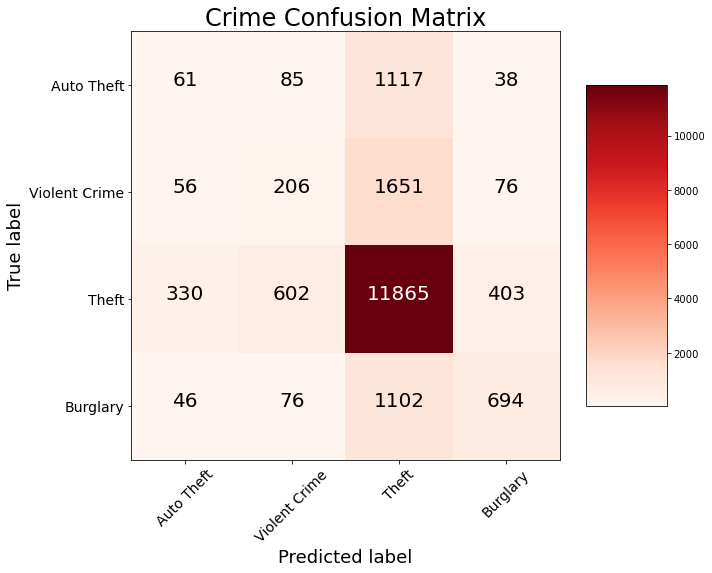

In [97]:
#Create a Confusion Matrix visual
confusion = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(confusion, classes = ['Auto Theft', 'Violent Crime', 'Theft', 'Burglary'],
                      title = 'Crime Confusion Matrix')

In [98]:
# Print out confusion matrix and all results
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

# call model print function
print_model_output(y_test, y_pred)

Confusion Matrix

[[   61    85  1117    38]
 [   56   206  1651    76]
 [  330   602 11865   403]
 [   46    76  1102   694]]

Accuracy: 0.70

Micro Precision: 0.70
Micro Recall: 0.70
Micro F1-score: 0.70

Macro Precision: 0.42
Macro Recall: 0.35
Macro F1-score: 0.37

Weighted Precision: 0.63
Weighted Recall: 0.70
Weighted F1-score: 0.65

Classification Report

               precision    recall  f1-score   support

   Auto Theft       0.12      0.05      0.07      1301
Violent Crime       0.21      0.10      0.14      1989
        Theft       0.75      0.90      0.82     13200
     Burglary       0.57      0.36      0.44      1918

     accuracy                           0.70     18408
    macro avg       0.42      0.35      0.37     18408
 weighted avg       0.63      0.70      0.65     18408



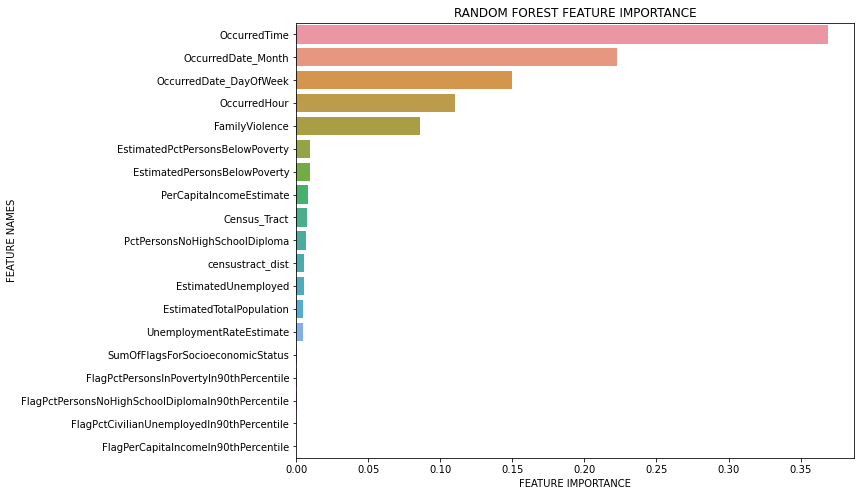

In [99]:
#call the Feature importance visualization function
plot_feature_importance(rf_model.feature_importances_,X.columns,'RANDOM FOREST')

In [100]:
print(rf_model.feature_importances_)
print(f" There are {len(rf_model.feature_importances_)} features in total")

[8.58585826e-02 3.68773883e-01 7.19177383e-03 4.80296240e-03
 9.44551655e-03 9.46178988e-03 3.47699237e-04 5.30541903e-03
 4.69930640e-03 1.59020546e-04 6.83979100e-03 2.75785488e-04
 8.38192187e-03 1.23815394e-04 7.37889268e-04 2.22788711e-01
 1.49426589e-01 1.09945254e-01 5.43428948e-03]
 There are 19 features in total
